<a href="https://colab.research.google.com/github/pi4imu/work-in-iki/blob/master/exploring_emcee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

In [ ]:
! pip install emcee
! pip install corner

import emcee
import corner

# Данные

Подгрузим все данные.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/IKI/Микролинзирование/

#lensPlane1=fits.open("maps/IRIS417.fits")[0].data
#lensPlane2=fits.open("maps/IRIS314.fits")[0].data

Mounted at /content/drive
/content/drive/My Drive/IKI/Микролинзирование


Незашумленные кривые блеска:

In [105]:
filename = 'data/refE5R50M20Ni2m2b5m3Z01_h5.ubv' 
model_curves = pd.read_csv(filename, header=0, delim_whitespace=True)

t1 = np.array(model_curves.time.values)      
lc1 = np.array(model_curves.F160W.values)

t_min = 20
cadence = 300

t1_grid = np.linspace(t_min, np.max(t1), cadence) # зададим сетку, чтобы точно контролировать количество точек и временной интервал
m1 = np.interp(t1_grid, t1, lc1)  # линейная интерполяция кривой lc1 на новую сетку t1_grid

Сдвинем кривую по времени и магнитуде:

In [106]:
dt_true = 50.            

magn_ratio = 1.4

dm_true = -2.5*np.log10(magn_ratio)
print(dm_true)

t2_grid = t1_grid + dt_true # второе изображение
m2 = m1 + dm_true

-0.365320089195595


Функция для единого оформления графиков:

In [107]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (7,5)

def grafik():

  plt.title('Кривые блеска SN Refsdal', fontsize=15)
  plt.xlabel('Время (в днях) с момента взрыва сверхновой', fontsize=15)
  plt.ylabel('Блеск', fontsize=15)
  plt.ylim(28.5, 26)
  plt.legend()
  plt.grid()
  plt.show()

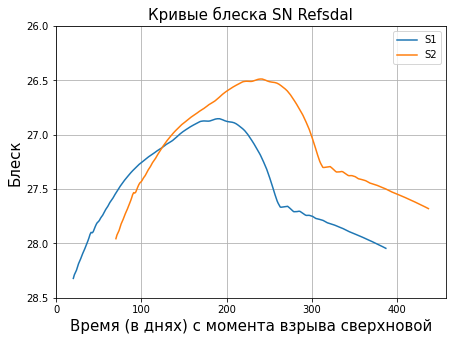

In [108]:
plt.plot(t1_grid, m1, label="S1")
plt.plot(t2_grid, m2, label="S2")

grafik()

# Добавляем микролинзирование

Добавим шум (пока что обычный гауссовый):

In [109]:
#fluct = pd.read_csv('delays6.csv').to_numpy()[0]
#center = (fluct[0], fluct[1])
#length = int(fluct[2])
#time_grid = fluct[3:3+length]
#dm_gauss = fluct[3+length:3+2*length]
#dm_flat = fluct[3+2*length:3+3*length]

#print('center =', center)
#print('length =', length)
#print(time_grid)
#print(dm_gauss)
#print(dm_flat)
#len(dm_flat)

In [110]:
microlensing_noise1 = np.random.normal(0., 0.1, len(t1_grid)) #здесь должна быть случайная реализация шума, извлеченного из карт микролинзирования
microlensing_noise2 = np.random.normal(0., 0.1, len(t2_grid)) #десь должна быть другая случайная реализация шума

lc1_noise = m1 + microlensing_noise1
lc2_noise = m2 + microlensing_noise2

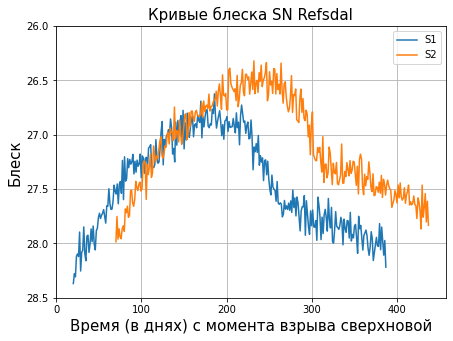

In [112]:
plt.plot(t1_grid, lc1_noise, label="S1")
plt.plot(t2_grid, lc2_noise, label="S2")

#lc2_noise_shifted = np.interp(t1_grid + dt_true, t2_grid, lc2_noise) - dm_true

#plt.plot(t1_grid, lc2_noise_shifted, label="S2 shifted")

#from scipy import interpolate

#func = interpolate.interp1d(t2_grid, lc2_noise)
#lc2_noise_shifted = func(t1_grid + dt_true) - dm_true

#plt.plot(t1_grid, lc2_noise_shifted, label="S2 shifted")

grafik()

In [113]:
#delta_t = np.arange(time_delay-50, time_delay+50, 0.1) # сетка по временным задержкам
#chi2 = delta_t*0.

#N = len(t1_grid) # количество точек
#s = 0.05
#k = dm

#for i in range(len(delta_t)): 

#  new_grid = t2_grid - delta_t[i]

#  lc1_wum_shifted = np.interp(new_grid, t1_grid, lc1_wum)

#  chi2[i] = np.sum( np.abs(lc2_wum - lc1_wum_shifted - k)**2 )/N/s**2

#print(delta_t[np.argmin(chi2)])
#plt.plot(delta_t, chi2)
#plt.show()

# emcee

Зададим необходимые функции. Логика следующая: мы "кормим" алгоритм данными из изображения S2, а потом сдвигаем их по времени и магнитуде и сравниваем с изображением S1.

In [115]:
def model(params, x1, x2, y2):
    dt, dmu, sigmu = params
    #func = interpolate.interp1d(x2, y2)
    #return func(x1 + dt) - dmu
    return np.interp(x1 + dt, x2, y2) - dmu

def lnlike(params, x1, y1, x2, y2):
    dt, dmu, sigmu = params
    lnlike = -0.5 * np.sum( ( (y1 - model(params, x1, x2, y2))/sigmu )**2 + np.log(2*np.pi*sigmu**2) )
    return lnlike

def lnprior(params):
    dt, dmu, sigmu = params
    if (0. < dt < 100. and -5. < dmu < 5. and 0. < sigmu < 1.):
        return 0.0
    return -np.inf

def lnprob(params, x1, y1, x2, y2):
    lp = lnprior(params)
    if np.isfinite(lp):
      return lp + lnlike(params, x1, y1, x2, y2)
    else:
      return -np.inf

Используем scipy.optimize для поиска подходящих начальных параметров. It’s worth noting that the optimize module minimizes functions whereas we would like to maximize the likelihood. This goal is equivalent to minimizing the negative likelihood (or in this case, the negative log likelihood). 

In [153]:
from scipy.optimize import minimize

#np.random.seed(45)  

lnlike1 = lambda *args: -lnlike(*args)

initial = np.array([dt_true, dm_true, 0.1]) + 0.01 * np.random.randn(3)

optim = minimize( lnlike1, initial, args = (t1_grid, lc1_noise, t2_grid, lc2_noise) )

print("dt = {0:.3f}".format(optim.x[0]))
print("dm = {0:.3f}".format(optim.x[1]))
print("sigmu = {0:.3f}".format(optim.x[2]))

dt = 50.587
dm = -0.355
sigmu = 0.119


In [154]:
nwalkers = 100

initial = optim.x # [51., -2.5*np.log10(1.35), 0.1000]

ndim = len(initial)

p0 = [np.array(initial) + 1e-8 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = (t1_grid, lc1_noise, t2_grid, lc2_noise) )

#p0, _, _ = sampler.run_mcmc(p0, 500, progress=True)
#sampler.reset()

sampler.run_mcmc(p0, 1000, progress = True)

!clear

100%|██████████| 1000/1000 [00:04<00:00, 235.08it/s]


Text(0.5, 0, 'step number')

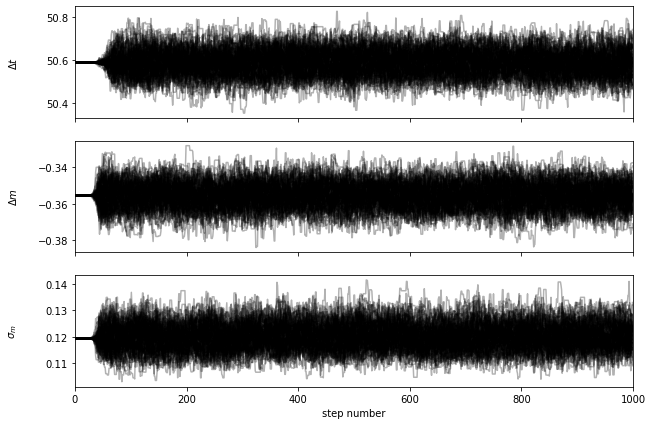

In [155]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)

chain = sampler.get_chain()

labels = ['$\Delta t$', '$\Delta m$', '$\sigma_m$']

for i in range(ndim):
    ax = axes[i]
    ax.plot(chain[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(chain))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [145]:
#tau = sampler.get_autocorr_time()
#print(tau)

In [146]:
#flat_samples = sampler.get_chain()#discard=400, thin=1, flat=False)
#print(flat_samples.shape)

# Результаты

Наконец, нарисуем графики:

True dt = 50.000
True dm = -0.365
Best dt = 50.587
Best dmu = -0.355


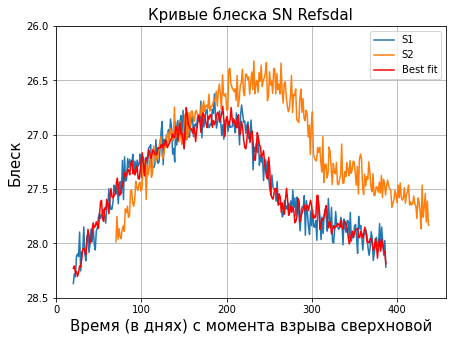

In [157]:
def plotter(sampler, show_all):
    
    plt.plot(t1_grid, lc1_noise, label='S1')
    plt.plot(t2_grid, lc2_noise, label='S2')

    samples = sampler.flatchain

    if show_all:
      for s in samples[np.random.randint(len(samples), size=50)]:
        plt.plot(t1_grid, model(s, t1_grid, t2_grid, lc2_noise), color="r", alpha=0.1)
    else:
      s  = samples[np.argmax(sampler.flatlnprobability)]
      print('Best dt = {0:.3f}'.format(s[0]))
      print('Best dmu = {0:.3f}'.format(s[1])) 
      #print('or best magnification ratio = {0:.3f}'.format(10**(-0.4*s[1])) )
      best_fit_model = model(s, t1_grid, t2_grid, lc2_noise)
      plt.plot(t1_grid, best_fit_model, color="r", label='Best fit')
    
    grafik()

print('True dt = {0:.3f}'.format(dt_true))
print('True dm = {0:.3f}'.format(dm_true))

plotter(sampler, show_all=False)

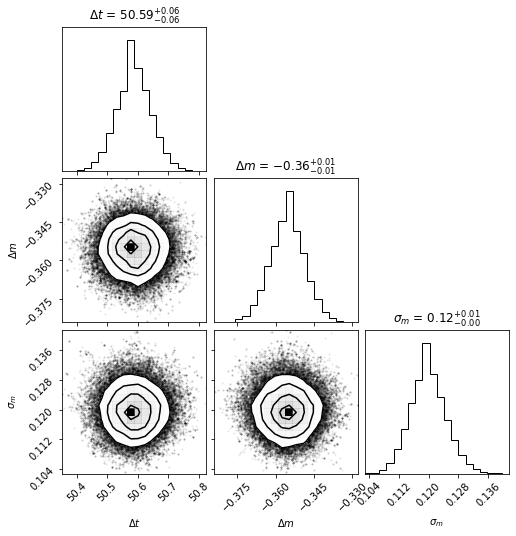

In [160]:
fig = corner.corner(sampler.flatchain, show_titles=True, labels=['$\Delta t$', '$\Delta m$', '$\sigma_m$']) 
                    #truths=[dt_true, dm_true, 0.1], scale_hist=True, quantiles=[0.16, 0.5, 0.84])

In [159]:
from IPython.display import display, Math

flat_samples = sampler.get_chain(discard=0, thin=1, flat=False)

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, :, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.2f}_{{-{1:.2f}}}^{{{2:.2f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>